### Imports ###

In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.cluster.util import cosine_distance
import networkx as nx
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud

### Importing the Dataset 

In [ ]:
df = pd.read_csv("IK_Trump.csv", engine='python', encoding='latin1')
df.head(5)

,ArticleID,ArticleTitle,ArticleText,ArticleSource
0,0,"On the Coronavirus, Pakistans Government Is M...","During a televised broadcast on March 22, Paki...",https://foreignpolicy.com/2020/05/11/on-corona...
1,1,Pakistan Plans Another COVID-19 Lockdown. Will...,The government in Pakistan is considering the ...,https://thediplomat.com/2020/05/pakistan-plans...
2,2,COVID-19: Pakistan has a dependency syndrome...,As Pakistan grapples to combat coronavirus wit...,https://gulfnews.com/world/asia/pakistan/covid...
3,3,COVID19 and Pakistan: The Economic Fallout,As Pakistan grapples to combat coronavirus wit...,https://www.orfonline.org/research/covid19-and...
4,4,Donald Trump says hes taking hydroxychloroqui...,President Donald Trump said hes taking antima...,https://www.theverge.com/2020/5/18/21262873/tr...


### Dispaying the Text contained within an article

In [ ]:
df['ArticleText'][2]

'As Pakistan grapples to combat coronavirus with increasing number of cases, Prime Minister Imran Khan has urged the need to build its own reliable medical infrastructure.\r\n\x93The coronavirus has brought to the fore that Pakistan needs to build its medical infrastructure and reduce dependency on foreign aid,\x94 added Imran.\r\nSpeaking during this visit to COMSTECH exhibition in Islamabad on Wednesday, Prime Minister Imran said:\x93We have a dependency syndrome; we don\x92t have that self-belief, we didn\x92t progress towards knowledge economy because we didn\x92t spend on education and research. Pakistanis excel once they immigrate; why can\x92t you create that system here?\x94\x93\x93We have to focus on building our medical infrastructure so that we are prepared for any such emergency situation in the future,\x94  he said and added that the COVID-19 crisis provided an opportunity to produce locally manufactured ventilators and protective equipment as everything cannot be imported

In [ ]:
df['ArticleText'][5]

'President Donald Trump has told graduates of the country\'s top military academy that the US forces are "not the policeman of the world" days after threatening to deploy active troops to quell protests across the country sparked by the police killing of an unarmed Black man. Speaking to new graduates of the United States Military Academy at West Point on Saturday, Trump praised the "righteous glory of the American warrior" but largely side-stepped the recent controversies of racial unrest and the military\'s role in putting down the nationwide protests that followed the May 25 death of George Floyd in Minnesota after a white officer kneeled on his neck for almost nine minutes. What has made America unique is the durability of its institutions against the passions and prejudices of the moment. When times are turbulent, when the road is rough, what matters most is that which is permanent, timeless, enduring and eternal," Trump said, in one of the few apparent references to the domestic 

### Function to read Text from the Article and returning list of sentences ###

In [ ]:
def read_article_text(article_id):
    article = df['ArticleText'][article_id].split(". ")
    sentences = []

    for sentence in article:
        sentences.append(sentence.replace("[^a-zA-Z]", " ").split(" ")) 
    sentences.pop() 
    
    return sentences

### Function to create similarity matrix




In [ ]:
def create_similarity_matrix(sentences, stop_words):
    
    similarity_matrix = np.zeros((len(sentences), len(sentences)))
    print("length of sentences is |",len(sentences))
 
    for index1 in range(len(sentences)):
      
        for index2 in range(len(sentences)):
            if index1 == index2: 
                
                continue 
                
            similarity_matrix[index1][index2] = sentence_similarity(sentences[index1], sentences[index2], stop_words)
            
           
    return similarity_matrix

### Function to find cosine similarity/distance between sentences



In [ ]:
def sentence_similarity(sent1, sent2, stopwords=None):
    if stopwords is None:
        stopwords = []
 
    sent1 = [w.lower() for w in sent1]
    sent2 = [w.lower() for w in sent2]
 
    all_words = list(set(sent1 + sent2))
    
    vector1 = [0] * len(all_words)
    vector2 = [0] * len(all_words)
 
    # build the vector for the first sentence
    for w in sent1:
        if w in stopwords:
            continue
        
        vector1[all_words.index(w)] += 1
        
 
    # build the vector for the second sentence
    for w in sent2:
        if w in stopwords:
            continue
        vector2[all_words.index(w)] += 1
        
        
    
    return (1 - cosine_distance(vector1, vector2))


### Function Genearting the Word Cloud to emphasized the Text Summarizer


In [ ]:
def word_cloud_generate(file):
    summary = ""
    with open(file, encoding='cp1252') as f:
        summary = ''.join(f.readlines())
            
    wordcloud = WordCloud(width=1600, height=800).generate(summary)
    plt.figure( figsize=(16,8), facecolor='k')
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.savefig('wordcloud.png', facecolor='k', bbox_inches='tight')   

### Function to Create Text Summary




In [ ]:
def text_summary(article_id, top_n=3):
   # nltk.download("stopwords")
    stop_words = stopwords.words('english')
    summarize_text = []

    # Step 1 - Read text and split it to setences.
    sentences =  read_article_text(article_id)

    # Step 2 - Generate Similary Martix across sentences
    sentence_similarity_martix = create_similarity_matrix(sentences, stop_words)
    
    # Step 3 - Rank sentences in similarity martix
    sentence_similarity_graph = nx.from_numpy_array(sentence_similarity_martix)
    
    scores = nx.pagerank(sentence_similarity_graph)
   # score is dictionary with key = node and value is its rank
   
    # creating the graph for similarity matrix.
    nx.draw(sentence_similarity_graph,with_labels=True)
    
    # Step 4 - Sort the rank and pick top sentences
    ranked_sentence = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)    
   
    # ranked_sentences are the list sorted in descending order sentences with their rank. 
    

    for i in range(top_n):
      summarize_text.append(" ".join(ranked_sentence[i][1]))

    # Step 5 - Offcourse, output the summarize text
    print("Summarize Text: \n", ". ".join(summarize_text))
    
    # Step 6 writing the summarize text into a file
    with open('summary.txt','w',encoding='utf-8') as f:
        for text in summarize_text:
            #text = text.encode('utf-8')
            print(text, file=f)  
    # Step 7 generating word cloud of summarize text
    word_cloud_generate('./summary.txt')

### Prompting the User to select and article from the List

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hawke\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


length of sentences is | 42
Summarize Text: 
 The government in Pakistan is considering the imposition of another countrywide lockdown if the COVID-19 situation continues to get worse. Pakistan has never implemented a complete lockdown in a true sense. With the virus spread now hitting all corners of the country and transmission patterns developing in rural areas, it is unclear if another lockdown is the solution or if it can be implemented at all


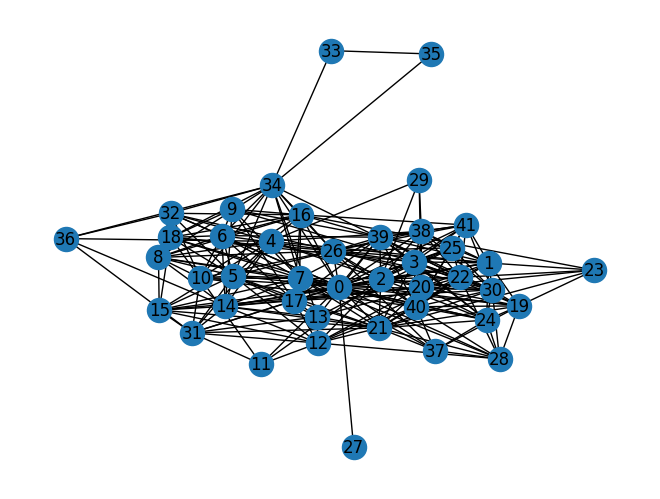

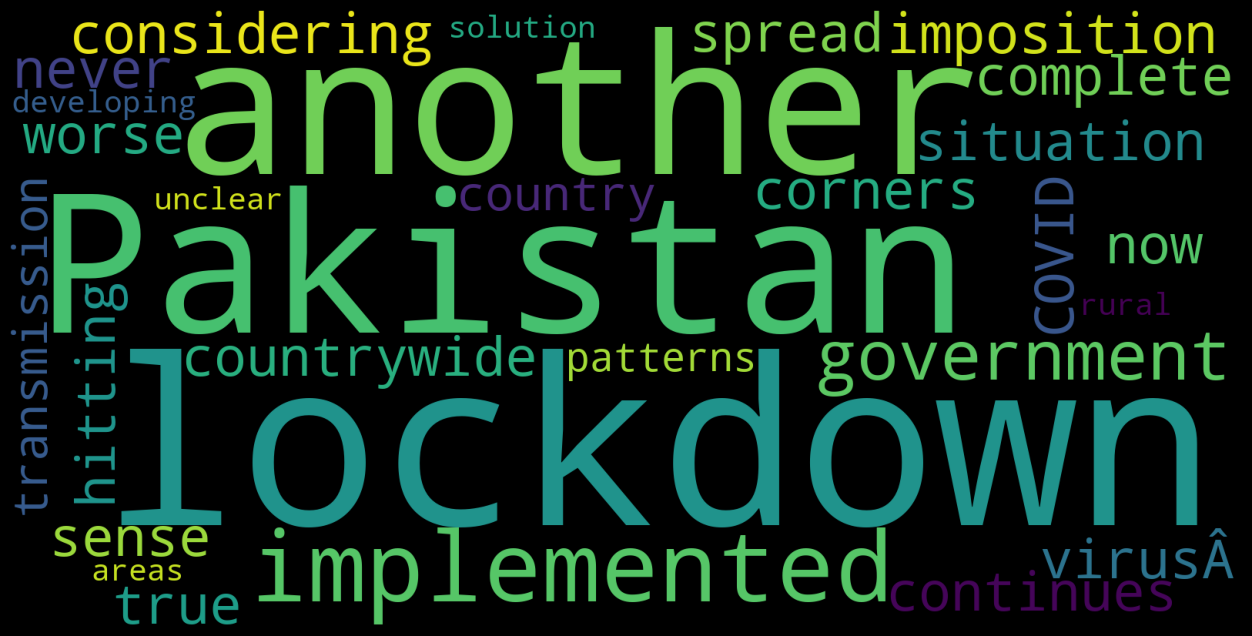

In [ ]:
import nltk
nltk.download('stopwords')
article_id = input("Enter the index of Article index ID for Summarization (0 to 5): ")
article_id=int(article_id)
text_summary(article_id)